# **Food Recognition and Calorie Estimation**

In [41]:
#imports & device
import io
import base64
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [42]:
#functions to draw simple food icons (64x64)

SIZE = (64,64)

def draw_pizza():
    img = Image.new("RGBA", SIZE, (255,255,255,255))
    draw = ImageDraw.Draw(img)
    # triangle slice
    w,h = SIZE
    draw.polygon([(w*0.5,h*0.15),(w*0.9,h*0.85),(w*0.1,h*0.85)], fill=(255,200,0))  # cheese
    # crust
    draw.ellipse((w*0.1,h*0.75,w*0.9,h*0.95), fill=(210,160,90))
    # pepperoni
    for x,y in [(0.5,0.45),(0.65,0.6),(0.35,0.6)]:
        draw.ellipse((w*x-6,h*y-6,w*x+6,h*y+6), fill=(180,40,40))
    return img.convert("RGB")

def draw_burger():
    img = Image.new("RGB", SIZE, (255,255,255))
    draw = ImageDraw.Draw(img)
    w,h = SIZE
    # top bun
    draw.ellipse((w*0.15,h*0.12,w*0.85,h*0.42), fill=(222,158,72))
    # lettuce
    draw.rectangle((w*0.2,h*0.38,w*0.8,h*0.5), fill=(92,170,63))
    # patty
    draw.rectangle((w*0.2,h*0.48,w*0.8,h*0.62), fill=(110,55,30))
    # bottom bun
    draw.ellipse((w*0.15,h*0.58,w*0.85,h*0.78), fill=(222,158,72))
    return img

def draw_icecream():
    img = Image.new("RGB", SIZE, (255,255,255))
    draw = ImageDraw.Draw(img)
    w,h = SIZE
    # cone
    draw.polygon([(w*0.5,h*0.85),(w*0.25,h*0.45),(w*0.75,h*0.45)], fill=(210,160,90))
    # scoop
    draw.ellipse((w*0.3,h*0.2,w*0.7,h*0.55), fill=(255,200,220))
    # sprinkles
    for pos in [(0.45,0.35),(0.55,0.3),(0.6,0.42),(0.38,0.33)]:
        draw.rectangle((w*pos[0],h*pos[1],w*(pos[0]+0.01),h*(pos[1]+0.02)), fill=(150,100,200))
    return img

def draw_sandwich():
    img = Image.new("RGB", SIZE, (255,255,255))
    draw = ImageDraw.Draw(img)
    w,h = SIZE
    # top bread
    draw.rectangle((w*0.15,h*0.18,w*0.85,h*0.32), fill=(210,160,90))
    # fillings
    draw.rectangle((w*0.18,h*0.32,w*0.82,h*0.44), fill=(92,170,63)) # lettuce
    draw.rectangle((w*0.18,h*0.44,w*0.82,h*0.56), fill=(200,60,60)) # tomato/meat
    # bottom bread
    draw.rectangle((w*0.15,h*0.56,w*0.85,h*0.7), fill=(210,160,90))
    return img

def draw_salad():
    img = Image.new("RGB", SIZE, (255,255,255))
    draw = ImageDraw.Draw(img)
    w,h = SIZE
    # bowl
    draw.ellipse((w*0.12,h*0.45,w*0.88,h*0.85), fill=(200,200,230))
    # greens
    for _ in range(8):
        x = random.uniform(0.25,0.75)
        y = random.uniform(0.35,0.6)
        draw.ellipse((w*(x-0.08),h*(y-0.08),w*(x+0.08),h*(y+0.08)), fill=(60,160,60))
    return img

def draw_dosa():
    img = Image.new("RGB", SIZE, (255,255,255))
    draw = ImageDraw.Draw(img)
    w,h = SIZE
    # dosa triangle
    draw.polygon([(w*0.1,h*0.2),(w*0.9,h*0.5),(w*0.1,h*0.8)], fill=(210,160,80))
    # chutney circle
    draw.ellipse((w*0.72,h*0.58,w*0.84,h*0.7), fill=(220,40,40))
    return img


In [43]:
# generate one example per class and encode to base64 strings (embedding)
icon_funcs = {
    "pizza": draw_pizza,
    "burger": draw_burger,
    "ice_cream": draw_icecream,
    "sandwich": draw_sandwich,
    "salad": draw_salad,
    "dosa": draw_dosa
}

# generate and base64-encode one canonical image per class (demonstration of embedding)
embedded_b64 = {}
for name, fn in icon_funcs.items():
    img = fn().resize((64,64))
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    b = buf.getvalue()
    embedded_b64[name] = base64.b64encode(b).decode('ascii')

# show lengths to confirm embedding
for k in embedded_b64:
    print(k, "b64 len:", len(embedded_b64[k]) )


pizza b64 len: 704
burger b64 len: 508
ice_cream b64 len: 600
sandwich b64 len: 356
salad b64 len: 640
dosa b64 len: 524


In [44]:
#decode base64 and build many slightly-augmented images per class
def decode_b64_to_pil(b64str):
    b = base64.b64decode(b64str)
    return Image.open(io.BytesIO(b)).convert("RGB")

# decode canonical and generate dataset by adding small variations
all_images = []
all_labels = []
for label, b64str in embedded_b64.items():
    base_img = decode_b64_to_pil(b64str)
    for i in range(60):  # 60 images per class -> 6*60 = 360 total
        img = base_img.copy()
        # small augmentations: random rotate, slight scale, and noise
        if random.random() < 0.6:
            angle = random.uniform(-15,15)
            img = img.rotate(angle, resample=Image.BILINEAR, fillcolor=(255,255,255))
        if random.random() < 0.5:
            scale = random.uniform(0.9,1.1)
            nw = max(1,int(64*scale))
            img = img.resize((nw,nw), Image.BILINEAR)
            img = img.resize((64,64), Image.BILINEAR)
        # add tiny speckle noise
        arr = np.array(img).astype(np.int16)
        noise = np.random.randint(-6,7,arr.shape)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        img = Image.fromarray(arr)
        all_images.append(img)
        all_labels.append(label)

print("Total images generated:", len(all_images))


Total images generated: 360


In [45]:
# shuffle & split
combined = list(zip(all_images, all_labels))
random.shuffle(combined)
all_images, all_labels = zip(*combined)
all_images, all_labels = list(all_images), list(all_labels)

# map labels to indices
classes = sorted(list(embedded_b64.keys()))
label2idx = {c:i for i,c in enumerate(classes)}
idx2label = {i:c for c,i in label2idx.items()}

# prepare transforms and datasets
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class EmbeddedFoodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = transforms.ToTensor()(img)
        lbl = label2idx[self.labels[idx]]
        return img_t, lbl

# split
n = len(all_images)
split = int(0.8 * n)
train_imgs, train_labels = all_images[:split], all_labels[:split]
test_imgs, test_labels = all_images[split:], all_labels[split:]

train_ds = EmbeddedFoodDataset(train_imgs, train_labels, transform=transform)
test_ds = EmbeddedFoodDataset(test_imgs, test_labels, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print("Classes:", classes)
print("Train size:", len(train_ds), "Test size:", len(test_ds))


Classes: ['burger', 'dosa', 'ice_cream', 'pizza', 'salad', 'sandwich']
Train size: 288 Test size: 72


In [46]:
#small CNN
class SmallCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*8*8, 128), nn.ReLU(),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = SmallCNN(n_classes=len(classes)).to(device)
print(model)


SmallCNN(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=4096, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [47]:
# train
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

epochs = 8
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        opt.zero_grad()
        out = model(imgs)
        loss = loss_fn(out, lbls)
        loss.backward()
        opt.step()
        running_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(out, dim=1)
        running_correct += (preds == lbls).sum().item()
        running_total += imgs.size(0)
    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    print(f"Epoch {epoch+1}/{epochs} — Loss: {epoch_loss:.4f} — Acc: {epoch_acc:.4f}")


Epoch 1/8 — Loss: 1.6369 — Acc: 0.3160
Epoch 2/8 — Loss: 0.5597 — Acc: 0.9792
Epoch 3/8 — Loss: 0.0347 — Acc: 1.0000
Epoch 4/8 — Loss: 0.0011 — Acc: 1.0000
Epoch 5/8 — Loss: 0.0001 — Acc: 1.0000
Epoch 6/8 — Loss: 0.0000 — Acc: 1.0000
Epoch 7/8 — Loss: 0.0000 — Acc: 1.0000
Epoch 8/8 — Loss: 0.0000 — Acc: 1.0000


In [48]:
# evaluation
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        preds = torch.argmax(out, dim=1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
print("Test accuracy:", correct/total)


Test accuracy: 1.0


In [49]:
# prediction and calorie mapping
calorie_map = {
    "pizza": 285, "burger": 354, "ice_cream": 210,
    "sandwich": 250, "salad": 150, "dosa": 320
}

def predict_image(img_pil):
    model.eval()
    with torch.no_grad():
        t = transform(img_pil).unsqueeze(0).to(device)
        out = model(t)
        pred = torch.argmax(out, dim=1).item()
        label = idx2label[pred]
        calories = calorie_map.get(label, 0)
        return label, calories


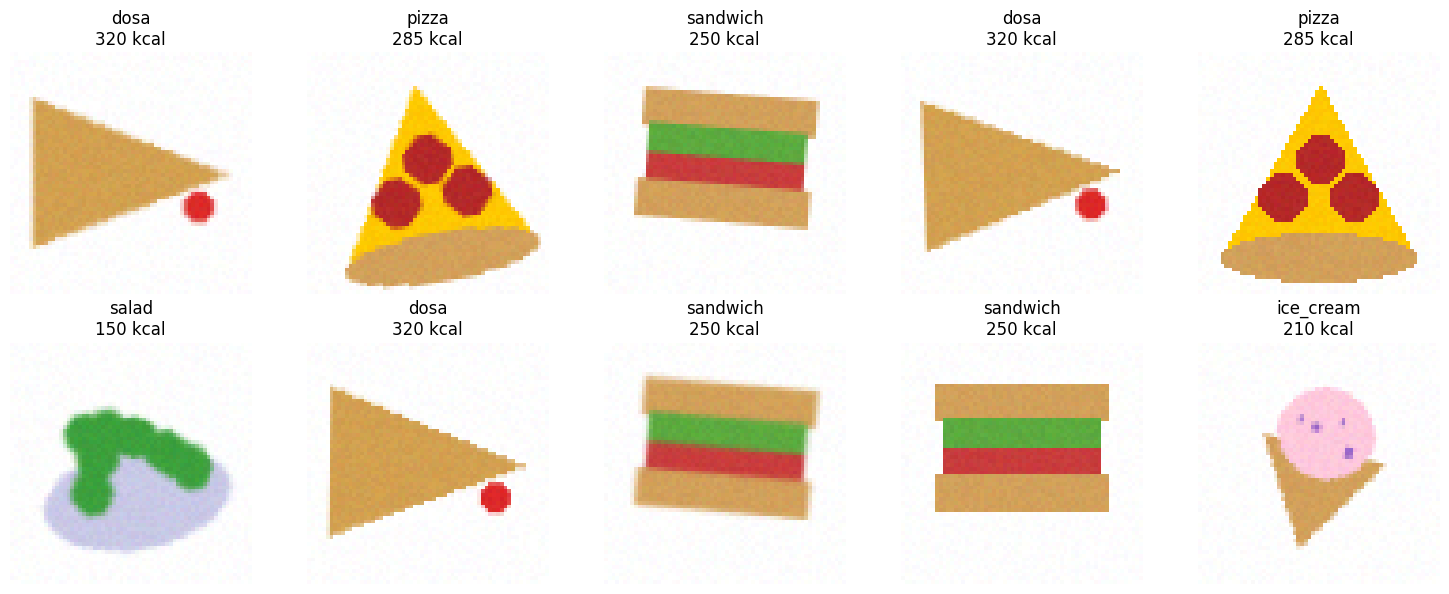

In [54]:
# visualize some predictions
import matplotlib.pyplot as plt

rows = 2
cols = 5
plt.figure(figsize=(15,6))
indices = random.sample(range(len(test_imgs)), rows*cols)
for i, idx in enumerate(indices):
    img = test_imgs[idx]
    pred_label, calories = predict_image(img)
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(f"{pred_label}\n{calories} kcal")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [51]:
# save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'classes': classes
}, "embedded_food_model.pth")
print("Saved embedded_food_model.pth")


Saved embedded_food_model.pth
